# importing libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [2]:
print(tf.__version__)

2.1.0


In [1]:
import sys
import numpy as np
import pickle # permet la sauvegarde du model 
import os # navigation dans le système( peut acceder aux fichiers et dossiers du pc)
import matplotlib.pyplot as plt
%matplotlib inline

import cv2 # traitement d'image
import time
import itertools
import random

from sklearn.utils import shuffle # melanger les items dans une array

import tensorflow as tf

from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [3]:

path = "/home/reem/Downloads/DATASETS/dataset/"

In [4]:
# determiner la liste des dossiers 
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [5]:
print(dir_list)

['001', '001_forg', '002', '002_forg', '003', '003_forg', '004', '004_forg', '006', '006_forg', '009', '009_forg', '012', '012_forg', '013', '013_forg', '014', '014_forg', '015', '015_forg', '016', '016_forg', '017', '017_forg', '018', '018_forg', '019', '019_forg', '020', '020_forg', '021', '021_forg', '022', '022_forg', '023', '023_forg', '024', '024_forg', '025', '025_forg', '026', '026_forg', '027', '027_forg', '028', '028_forg', '029', '029_forg', '030', '030_forg', '031', '031_forg', '032', '032_forg', '033', '033_forg', '034', '034_forg', '035', '035_forg', '036', '036_forg', '037', '037_forg', '038', '038_forg', '039', '039_forg', '040', '040_forg', '041', '041_forg', '042', '042_forg', '043', '043_forg', '044', '044_forg', '045', '045_forg', '046', '046_forg', '047', '047_forg', '048', '048_forg', '049', '049_forg', '050', '050_forg', '051', '051_forg', '052', '052_forg', '053', '053_forg', '054', '054_forg', '055', '055_forg', '056', '056_forg', '057', '057_forg', '058', '058

In [6]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    if "forg" in directory:
        forg_groups.append(directory)
    else :
        orig_groups.append(directory)

In [7]:
print(orig_groups)

['001', '002', '003', '004', '006', '009', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', 'epoch', 'epoch (1)']


In [8]:
def image_liste(dossier):
    images=os.listdir(path+dossier)
    images.sort()
    images = [path+dossier+'/'+x for x in images]
    return images

In [9]:
orig_image_liste=[]
for dossier in orig_groups:
    orig_image_liste.append(image_liste(dossier))

In [10]:
forg_image_liste=[]
for dossier in forg_groups:
    forg_image_liste.append(image_liste(dossier))

In [11]:
len(orig_image_liste),len(forg_image_liste)

(66, 64)

In [17]:
print(orig_image_liste[0][0])

/root/dataset/sign_data/train/001/001_01.PNG


### image visualisation

(-0.5, 219.5, 154.5, -0.5)

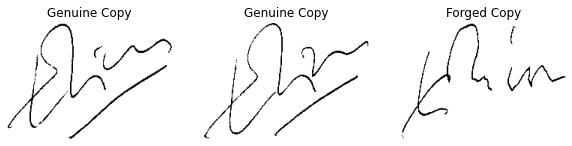

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
orig_img1 = cv2.imread(orig_image_liste[0][0],0)
orig_img2 = cv2.imread(orig_image_liste[0][1],0)
forg_img = cv2.imread(forg_image_liste[0][1],0)
ax1.imshow(orig_img1, cmap = 'gray')
ax2.imshow(orig_img2, cmap = 'gray')
ax3.imshow(forg_img, cmap = 'gray')

ax1.set_title('Genuine Copy')
ax1.axis('off')
ax2.set_title('Genuine Copy')
ax2.axis('off')
ax3.set_title('Forged Copy')
ax3.axis('off')

(-0.5, 466.5, 225.5, -0.5)

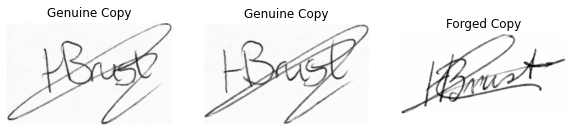

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
orig_img1 = cv2.imread(orig_image_liste[5][0],0)
orig_img2 = cv2.imread(orig_image_liste[5][1],0)
forg_img = cv2.imread(forg_image_liste[5][1],0)
ax1.imshow(orig_img1, cmap = 'gray')
ax2.imshow(orig_img2, cmap = 'gray')
ax3.imshow(forg_img, cmap = 'gray')

ax1.set_title('Genuine Copy')
ax1.axis('off')
ax2.set_title('Genuine Copy')
ax2.axis('off')
ax3.set_title('Forged Copy')
ax3.axis('off')

## image preprocessing

In [31]:
def background_preproce(image):
    for line in image:
        for pixel in line:
            for i in range(3):
                if pixel[i]> 180 :
                    pixel[i]=255
                else :
                    pixel[i]=0
                
    return image

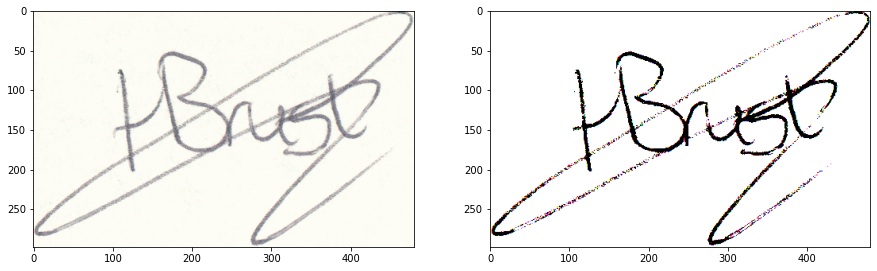

In [32]:
image = cv2.imread(orig_image_liste[5][0])
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15, 15))
ax1.imshow(image)
image2 = background_preproce(image)
ax2.imshow(image2)

In [13]:
def main_preprocess(image):
    norm_img = np.zeros((800,800))
    normalized=cv2.normalize(image, norm_img,0,255,cv2.NORM_MINMAX)
    resized=cv2.resize(normalized, (img_w, img_h))
    image_preprocess=background_preproce(resized)
    return (image_preprocess)

In [12]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

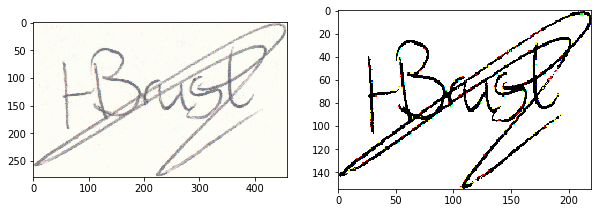

In [29]:
image = cv2.imread(orig_image_liste[5][1])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(image,  cmap = 'gray' )
ax2.imshow(main_preprocess(image),cmap = 'gray')


In [35]:

for dossier in orig_image_liste: 
    for img in dossier:
        image=cv2.imread(img)
        image2=main_preprocess(image)
        cv2.imwrite(img,image2) 

In [36]:
for dossier in forg_image_liste: 
    for img in dossier:
        image=cv2.imread(img)
        image2=main_preprocess(image)
        cv2.imwrite(img,image2)

## data preparation

In [13]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
      # Vu que pour chaque personne on a des nombres des signatures differents on va travailler avec 12signatures originales et 8signatures fraudé
        #on va creer des paires qui combinent aleatoirement deux signatures originales ou une signature originale et une fraude
        
        for orig, forg in zip(orig_groups, forg_groups):
            orig_sample=random.sample(orig, 12)
            orig_pairs.extend(list(itertools.combinations(orig_sample, 2)))
            for i in range(8):
                forg_pairs.extend(list(itertools.product(orig_sample[i:i+1], random.sample(forg, 8))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        #creer des groupes des paires avec leurs labels 
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            #img1 = cv2.resize(img1, (img_w, img_h))
            #img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

## modeling


model 1: bs=128,epoch=100

In [14]:
orig_train, orig_val, orig_test = orig_image_liste[:45], orig_image_liste[45:59], orig_image_liste[59:]
forg_train, forg_val, forg_test = forg_image_liste[:45], forg_image_liste[45:59], forg_image_liste[59:]

In [15]:
input_shape=(img_h, img_w, 1)

In [16]:
def euclidean_distance(vects):
    
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [17]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [18]:
def contrastive_loss(y_true, y_pred):
    

    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [19]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        init='glorot_uniform', dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, init='glorot_uniform', dim_ordering='tf'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform')) # softmax changed to relu
    
    return seq

In [20]:
input_shape=(img_h, img_w, 1)

In [21]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(input=[input_a, input_b], output=distance)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, kernel_size=(11, 11), activation="relu", name="conv1_1", strides=4, input_shape=(155, 220,..., data_format="channels_last", kernel_initializer="glorot_uniform")`
  
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)`
  import sys
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D((2, 2), data_format="channels_last")`
  if __name__ == '__main__':
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, kernel_size=(5, 5), activation="relu", name="conv2_1", strides=1, data_format="channels_last", kernel_initializer="glorot_uni

In [22]:
def create_pairs(orig_groups, forg_groups):
    orig_pairs = []
    forg_pairs = []
    
    for orig, forg in zip(orig_groups, forg_groups):
        orig_sample=random.sample(orig, 12)
        orig_pairs.extend(list(itertools.combinations(orig_sample, 2)))
        for i in range(8):
            forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 8))))
    return ( orig_pairs,forg_pairs)

In [23]:
a,b=create_pairs(orig_train,forg_train)
print(len(a),len(b))

2970 2880


In [24]:
c,d=create_pairs(orig_val,forg_val)
print(len(c),len(d))

924 896


In [25]:
e,f=create_pairs(orig_test,forg_test)
print(len(e),len(f))

330 320


In [26]:
batch_sz = 128
num_train_samples = len(a)+len(b)
num_val_samples = len(c)+len(d)
num_test_samples=len(e)+len(f)
num_train_samples, num_val_samples, num_test_samples

(5850, 1820, 650)

In [27]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-7, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

In [34]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/root/dataset/epoch/signet-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [35]:
results = model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/100
45/45 [==============================] - 16s 352ms/step - loss: 172.3105 - val_loss: 2.0303

Epoch 00001: saving model to /root/dataset/epoch/signet-bhsig260-001.h5
Epoch 2/100
45/45 [==============================] - 11s 246ms/step - loss: 162.2429 - val_loss: 2.0206

Epoch 00002: saving model to /root/dataset/epoch/signet-bhsig260-002.h5
Epoch 3/100
45/45 [==============================] - 10s 225ms/step - loss: 153.9460 - val_loss: 1.9382

Epoch 00003: saving model to /root/dataset/epoch/signet-bhsig260-003.h5
Epoch 4/100
45/45 [==============================] - 12s 256ms/step - loss: 146.8786 - val_loss: 1.9283

Epoch 00004: saving model to /root/dataset/epoch/signet-bhsig260-004.h5
Epoch 5/100
45/45 [==============================] - 11s 236ms/step - loss: 139.0973 - val_loss: 1.7484

Epoch 00005: saving model to /root/dataset/epoch/signet-bhsig260-005.h5
Epoch 6/100
45/45 [==============================] - 10s 225ms/step - loss: 131.5884 - val_loss: 1.8615

Epoch 0000

In [28]:
model.load_weights('/home/reem/Downloads/DATASETS/dataset/epoch _gpu/signet-bhsig260-023.h5')

In [33]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [44]:
test_gen

<generator object generate_batch at 0x7f14a4e2b8d0>

In [30]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

In [32]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.7219696969696969, 0.8934416997432713)

In [36]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

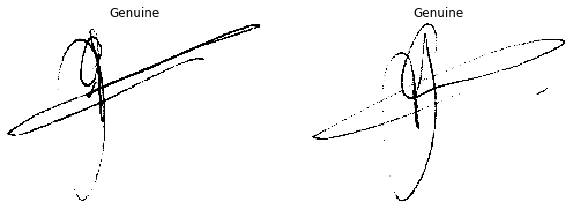

Difference Score =  0.8020828
Its a Genuine Signature


In [38]:
predict_score()

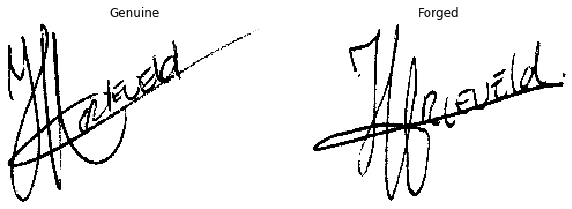

Difference Score =  1.0100545
Its a Forged Signature


In [40]:
predict_score()

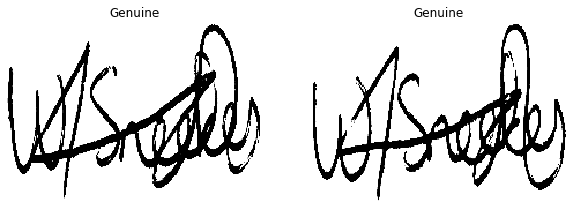

Difference Score =  0.8699818
Its a Genuine Signature


In [41]:
predict_score()

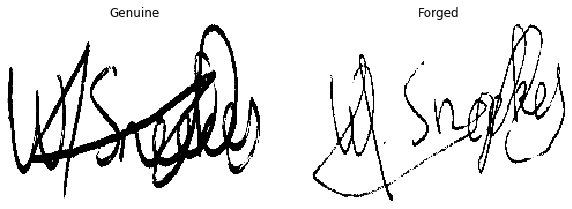

Difference Score =  1.0734489
Its a Forged Signature


In [42]:
predict_score()

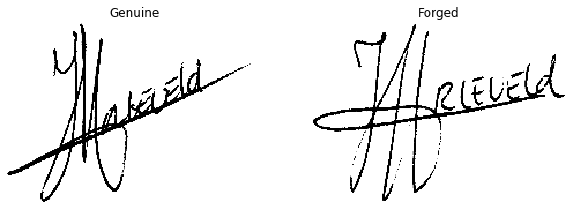

Difference Score =  1.033389
Its a Forged Signature


In [43]:
predict_score()

# Model 2
model 2: ajout d'un neurone 
bs=64
lr=1e-4

## verification du model


In [47]:
def create_base_network_signet2(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(128, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        init='glorot_uniform', dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(512, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, init='glorot_uniform', dim_ordering='tf'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform')) # softmax changed to relu
    
    return seq

In [48]:
# network definition
base_network2 = create_base_network_signet2(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network2(input_a)
processed_b = base_network2(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model1= Model(input=[input_a, input_b], output=distance)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, kernel_size=(11, 11), activation="relu", name="conv1_1", strides=4, input_shape=(155, 220,..., data_format="channels_last", kernel_initializer="glorot_uniform")`
  
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)`
  import sys
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D((2, 2), data_format="channels_last")`
  if __name__ == '__main__':
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, kernel_size=(5, 5), activation="relu", name="conv2_1", strides=1, data_format="channels_last", kernel_initializer="glorot_un

In [49]:
base_network2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 37, 53, 128)       15616     
_________________________________________________________________
batch_normalization_3 (Batch (None, 37, 53, 128)       148       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 26, 128)       0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 22, 30, 128)       0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 18, 26, 256)       819456    
_________________________________________________________________
batch_normalization_4 (Batch (None, 18, 26, 256)       72        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 12, 256)       

In [141]:
batch_sz = 128

In [142]:
rms2 = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model1.compile(loss=contrastive_loss, optimizer=rms2)

In [143]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks1 = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/root/dataset/epoch/model2-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [144]:
results1 = model1.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks1)

Epoch 1/100
45/45 [==============================] - 10s 227ms/step - loss: 4.7547 - val_loss: 1.4765

Epoch 00001: saving model to /root/dataset/epoch/model2-bhsig260-001.h5
Epoch 2/100
45/45 [==============================] - 9s 203ms/step - loss: 1.2509 - val_loss: 1.3488

Epoch 00002: saving model to /root/dataset/epoch/model2-bhsig260-002.h5
Epoch 3/100
45/45 [==============================] - 9s 197ms/step - loss: 1.2141 - val_loss: 1.3109

Epoch 00003: saving model to /root/dataset/epoch/model2-bhsig260-003.h5
Epoch 4/100
45/45 [==============================] - 9s 201ms/step - loss: 1.1147 - val_loss: 1.3147

Epoch 00004: saving model to /root/dataset/epoch/model2-bhsig260-004.h5
Epoch 5/100
45/45 [==============================] - 10s 214ms/step - loss: 0.9717 - val_loss: 1.0604

Epoch 00005: saving model to /root/dataset/epoch/model2-bhsig260-005.h5
Epoch 6/100
45/45 [==============================] - 11s 240ms/step - loss: 0.8394 - val_loss: 1.0403

Epoch 00006: saving model

In [172]:
model1.load_weights('/root/dataset/epoch/model2-bhsig260-030.h5')
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model1.predict([img1, img2])[0][0])

tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold


(0.7349905303030303, 0.5217214838881046)

In [34]:
pred

[0.65228254,
 1.0949231,
 0.8792179,
 0.8718195,
 0.9096044,
 0.9824777,
 1.2032925,
 0.80651253,
 0.74798894,
 1.0124406,
 0.84335965,
 1.0361693,
 0.98204416,
 0.79760426,
 0.7378544,
 0.8189749,
 0.9198497,
 0.8304938,
 0.6737098,
 0.8329226,
 0.7312805,
 0.76091796,
 0.8978471,
 0.5439447,
 0.77683115,
 0.77467823,
 0.7390338,
 0.84585786,
 0.840076,
 0.9454073,
 0.7857528,
 0.8654972,
 0.751993,
 0.80877286,
 0.4634417,
 0.7436733,
 0.9662714,
 0.6573732,
 0.9257646,
 0.9993627,
 0.86186886,
 0.92401606,
 0.82493126,
 0.75184494,
 0.9073313,
 0.6922942,
 0.95446223,
 0.9830578,
 0.75493336,
 0.8569251,
 0.73885787,
 0.81805056,
 1.3748313,
 0.90010303,
 1.0416042,
 0.7668339,
 0.70098484,
 1.0037031,
 1.0520408,
 1.1078286,
 1.0095766,
 0.99716914,
 0.9239363,
 1.1178356,
 0.798587,
 0.8719287,
 0.70526767,
 0.8062882,
 0.8057698,
 0.93776065,
 0.976856,
 0.9042189,
 0.96435666,
 0.88005185,
 0.7140136,
 0.8641989,
 1.1577574,
 0.7897631,
 0.85953975,
 0.8420649,
 1.1028945,
 0.77

In [35]:
print(round(pred[0]))

1.0


# Model3

In [1]:
def create_base_network_signet3(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(128, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        init='glorot_uniform', dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
       
    seq.add(Conv2D(512, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(726, kernel_size=(3, 3), activation='relu', name='conv3_3', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(726, kernel_size=(3, 3), activation='relu', name='conv3_5', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(726, kernel_size=(3, 3), activation='relu', name='conv3_4', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, init='glorot_uniform', dim_ordering='tf'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    
    
    
    seq.add(Dense(128, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform')) # softmax changed to relu
    
    return seq

In [2]:
# network definition
base_network3 = create_base_network_signet3(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network3(input_a)
processed_b = base_network3(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model2= Model(input=[input_a, input_b], output=distance)


batch_sz=128


rms2 = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model2.compile(loss=contrastive_loss, optimizer=rms2, metrics=['accuracy'])

# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks1 = [
    ReduceLROnPlateau(factor=0.01, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/root/dataset/epoch/model3-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

results1 = model2.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 50,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks1)

NameError: name 'input_shape' is not defined

In [195]:
model2.load_weights('/root/dataset/epoch/model3-bhsig260-025.h5')
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model2.predict([img1, img2])[0][0])

tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold


(0.7401041666666666, 0.3623793859872967)

# REFERENCES 